In [45]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import visvalingamwyatt as vw
from copy import deepcopy

In [46]:
ticker = "BTC-USD"
period = "2y"
interval = "1wk"
coeff = {"1m":1/24/60, "2m":1/24/30, "5m":1/24/12, "15m":1/24/4, "30m":1/24/2,
        "60m":1/24, "90m":1/16, "1h":1/24, "1d":1, "5d":5, "1wk":7, "1mo":30,
         "3mo":90}
data = yf.download(ticker, period=period, interval=interval)

[*********************100%***********************]  1 of 1 completed


In [47]:
def candles(ax, data, alpha=1):
    up = data[data.Close >= data.Open]
    down = data[data.Close < data.Open]
    col_up = 'green'
    col_down = 'red'
    col_shadow_up = 'black'
    col_shadow_down = 'black'
    width_body = (data.index[-1]-data.index[-2])*.8
    width_shadow = (data.index[-1]-data.index[-2])*.2
    width_body = .8 * coeff[interval]
    width_shadow = .2 * coeff[interval]
    ax.bar(up.index, up.Close-up.Open, width_body, bottom=up.Open, color=col_up, alpha=alpha)
    ax.bar(up.index, up.High-up.Close, width_shadow, bottom=up.Close, color=col_shadow_up, alpha=alpha)
    ax.bar(up.index, up.Low-up.Open, width_shadow, bottom=up.Open, color=col_shadow_up, alpha=alpha)
    ax.bar(down.index, down.Close-down.Open, width_body, bottom=down.Open, color=col_down, alpha=alpha)
    ax.bar(down.index, down.High-down.Open, width_shadow, bottom=down.Open, color=col_shadow_down, alpha=alpha)
    ax.bar(down.index, down.Low-down.Close, width_shadow, bottom=down.Close, color=col_shadow_down, alpha=alpha)

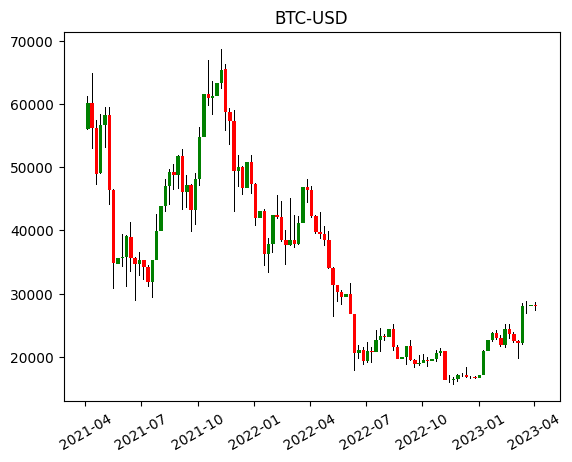

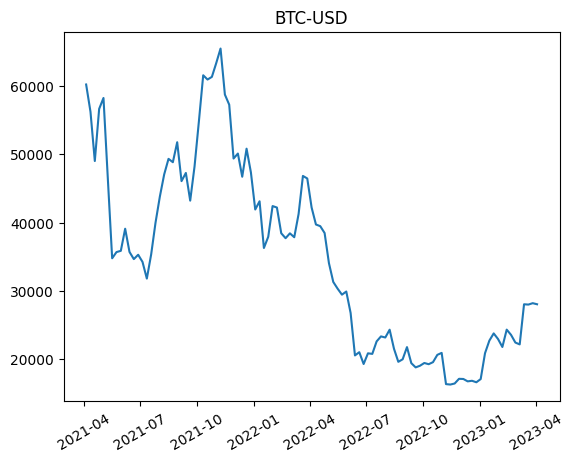

In [48]:
# Исходные данные
fig = plt.figure()
ax = fig.add_subplot()
candles(ax, data)
plt.title(ticker)
plt.xticks(rotation=30)
plt.show()

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(data.index, data.Close)
plt.title(ticker)
plt.xticks(rotation=30)
plt.show()

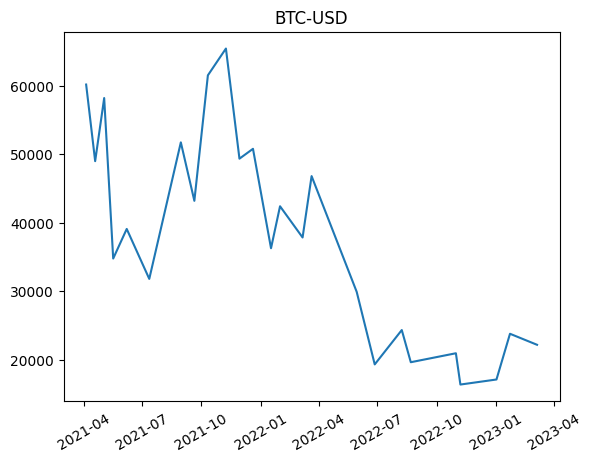

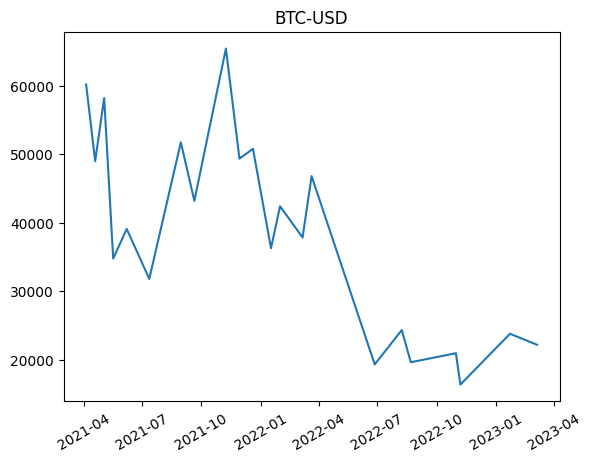

In [49]:
# Сглаживаем график и объединяем однонаправленные отрезки
def simplify(data):
    temp = [[i, data["Close"][i]] for i in range(len(data))]
    temp = vw.simplify(temp, number=25) 
    return data.iloc[[i[0] for i in temp]]
def simplify_monotone(data):
    temp = [0]
    for i in range(1, data.shape[0]-1):
        if (data["Close"][i+1]-data["Close"][i] > 0) != (data["Close"][i]-data["Close"][i-1] > 0):
            temp.append(i)
    temp.append(data.shape[0]-1)
    return data.iloc[temp]

res1 = simplify(data)
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(res1.index, res1.Close)
plt.title(ticker)
plt.xticks(rotation=30)
plt.show()

res2 = simplify_monotone(res1)
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(res2.index, res2.Close)
plt.title(ticker)
plt.xticks(rotation=30)
plt.show()

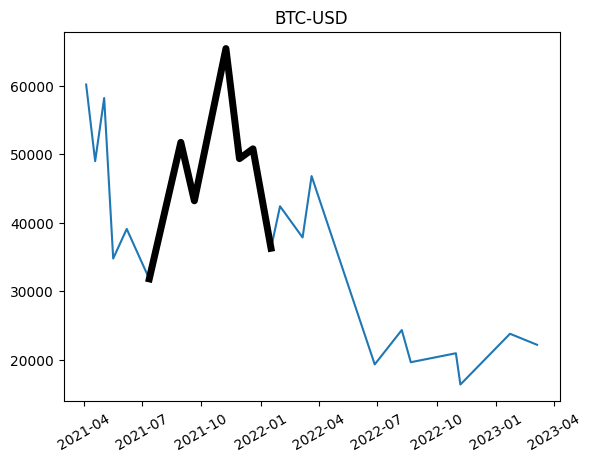

In [50]:
# Ищем паттерн
def search_head_and_shoulders(data):
    i = 0
    if data["Close"][0] > data["Close"][1]:
        i += 1
    res = []
    while i <= data.shape[0]-7:
        left = data["Close"][i+1]
        head = data["Close"][i+3]
        right = data["Close"][i+5]
        if head > left and head > right and head - max(left, right) > abs(left-right):
            res.append(data.iloc[i:i+7])
            i += 4
        i += 2
    return res

patterns = search_head_and_shoulders(res2)
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(res2.index, res2.Close)
for pattern in patterns:
    ax.plot(pattern.index, pattern.Close, lw=5, c="black")
plt.title(ticker)
plt.xticks(rotation=30)
plt.show()

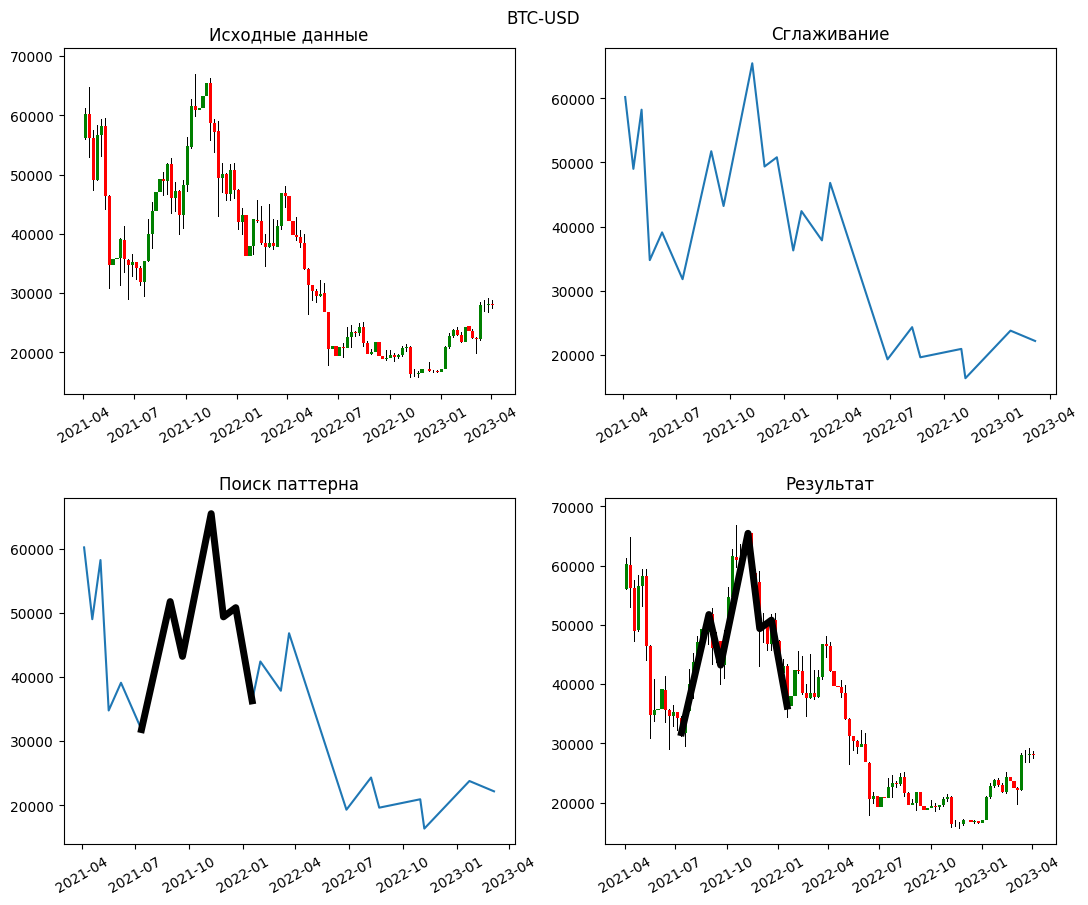

In [51]:
fig = plt.figure(figsize=[12.8, 9.6])

ax1 = fig.add_subplot(221)
candles(ax1, data)
ax1.set_title("Исходные данные")

ax2 = fig.add_subplot(222)
ax2.plot(res2.index, res2.Close)
ax2.set_title("Сглаживание")

ax3 = fig.add_subplot(223)
ax3.plot(res2.index, res2.Close)
for pattern in patterns:
    ax3.plot(pattern.index, pattern.Close, lw=5, c="black")
ax3.set_title("Поиск паттерна")

ax4 = fig.add_subplot(224)
candles(ax4, data)
for pattern in patterns:
    ax4.plot(pattern.index, pattern.Close, lw=5, c="black")
ax4.set_title("Результат")

fig.suptitle(ticker)
fig.subplots_adjust(top=0.94, hspace=0.3)
for ax in fig.axes:
    plt.setp(ax.get_xticklabels(), rotation=30)
plt.show()

Источники  
https://www.investopedia.com/terms/h/head-shoulders.asp  
https://martinfleischmann.net/line-simplification-algorithms/